In [18]:
!nvidia-smi

Tue Jan 17 14:47:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:73:00.0  On |                  N/A |
|  0%   49C    P8    28W / 320W |   2028MiB / 10240MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
import torch.nn as nn
import torch
import tqdm.notebook as tqdm
from IPython import display
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.covariance import EllipticEnvelope
from utils.dataset import load_compiled_data
from utils.head import mlp_reg, auxiliary_head, mlp_dual

device = torch.device('cuda:0')
reg_camera_1 = mlp_reg().to(device)
reg_camera_2 = mlp_reg().to(device)
aux_head = auxiliary_head().to(device)


reg_camera_1.train()
reg_camera_2.train()
aux_head.train()

auxiliary_head(
  (fc_1): Linear(in_features=256, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [26]:
offset = [[19.75390625, 248.5, 9.0, 5.5], [5.056640625, 248.5, 10.109375, 4.5]]
divider = [[1895.24609375, 395.75, 175.25, 151.0],
           [1909.443359375, 396.5, 172.640625, 83.5]]

trajectory_threshold = [800, 700]

train_data = load_compiled_data(ts=[1, 2, 5], ws=[1], rs=[
                                1, 2], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold, device=device, verbose=False)
test_data = load_compiled_data(ts=[1, 2, 5], ws=[1], rs=[
                               3], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold, device=device, verbose=False)

In [38]:
learning_rate = 1e-6
criterion = nn.MSELoss()
cam_1_complete_optimizer = torch.optim.Adam(list(reg_camera_1.parameters()) + list(aux_head.parameters()), lr=learning_rate)
cam_2_complete_optimizer = torch.optim.Adam(list(reg_camera_2.parameters()) + list(aux_head.parameters()), lr=learning_rate)

In [39]:
mapes_train = []
mapes_test= []

# All Camera Training

In [45]:
reg_camera_1.train()
reg_camera_2.train()
aux_head.train()

epochs = tqdm.tqdm(iterable=range(700000), leave=True)
for epoch in epochs:
    cam_1_complete_optimizer.zero_grad()
    cam_2_complete_optimizer.zero_grad()
    #optimizer_1_reg.zero_grad()
    #optimizer_2_reg.zero_grad()
    # camera_1
    loss_1 = criterion(aux_head(reg_camera_1(train_data['single']['cam_1']['x'])).squeeze(), train_data['single']['cam_1']['y'][:, 0]) * 10
    loss_1.backward()
    cam_1_complete_optimizer.step()
    #optimized_1_reg.step()
    # camera_2
    loss_2 = criterion(aux_head(reg_camera_2(train_data['single']['cam_2']['x'])).squeeze(), train_data['single']['cam_2']['y'][:, 0]) * 10
    loss_2.backward()
    cam_2_complete_optimizer.step()
    if epoch % 500 == 0:
        reg_camera_1.eval()
        reg_camera_2.eval()
        aux_head.eval()
        ypred_1 = aux_head(reg_camera_1(test_data['single']['cam_1']['x'])).squeeze()
        ypred_2 = aux_head(reg_camera_2(test_data['single']['cam_2']['x'])).squeeze()
        
        ypred_1_train = aux_head(reg_camera_1(train_data['single']['cam_1']['x'])).squeeze()
        ypred_2_train = aux_head(reg_camera_2(train_data['single']['cam_2']['x'])).squeeze()
        
        tloss_1 = criterion(ypred_1, test_data['single']['cam_1']['y'][:, 0]) * 10
        tloss_2 = criterion(ypred_2, test_data['single']['cam_2']['y'][:, 0]) * 10
        
        mape_test_1 = ((abs(ypred_1-test_data['single']['cam_1']['y'][:, 0])/ypred_1).mean() * 100).item()
        mape_test_2 = ((abs(ypred_2-test_data['single']['cam_2']['y'][:, 0])/ypred_2).mean() * 100).item()
        
        mape_train_1 = ((abs(ypred_1_train-train_data['single']['cam_1']['y'][:, 0])/ypred_1_train).mean() * 100).item()
        mape_train_2 = ((abs(ypred_2_train-train_data['single']['cam_2']['y'][:, 0])/ypred_2_train).mean() * 100).item()
        
        display.clear_output(wait=True)
        display.display(epochs.container)
        print("==========================\nEpoch {}".format(epoch))
        print(f'Train Camera 1 Loss : {loss_1.item()}')
        print(f'Train Camera 2 Loss : {loss_2.item()}\n')
        print(f'Test Camera 1 Loss  : {tloss_1.item()}')
        print(f'Test Camera 2 Loss  : {tloss_2.item()}\n')
        
        print(f'Train Camera 1 MAPE : {mape_train_1:.2f}%')
        print(f'Train Camera 2 MAPE : {mape_train_2:.2f}%\n')
        
        print(f'Test Camera 1 MAPE  : {mape_test_1:.2f}%')
        print(f'Test Camera 2 MAPE  : {mape_test_2:.2f}%')
        print("==========================\n")
        mapes_train.append([mape_train_1, mape_train_2])
        mapes_test.append([mape_test_1, mape_test_2])
        reg_camera_1.train()
        reg_camera_2.train()
        aux_head.train()

  1%|          | 5994/700000 [00:33<1:03:02, 183.47it/s]

Epoch 6000
Train Camera 1 Loss : 2.51322580879787e-05
Train Camera 2 Loss : 2.714420043048449e-05

Test Camera 1 Loss  : 3.5490229493007064e-05
Test Camera 2 Loss  : 3.148063478874974e-05

Train Camera 1 MAPE : 0.13%
Train Camera 2 MAPE : 0.14%

Test Camera 1 MAPE  : 0.18%
Test Camera 2 MAPE  : 0.17%



KeyboardInterrupt: 

In [33]:
learning_rate = 1e-6
optimizer_camera_2 = torch.optim.Adam(reg_camera_2.parameters(), lr=learning_rate)
optimizer_camera_1 = torch.optim.Adam(reg_camera_1.parameters(), lr=learning_rate)

In [44]:
reg_camera_1.train()
reg_camera_2.train()
aux_head.train()

epochs = tqdm.tqdm(iterable=range(700000), leave=True)
for epoch in epochs:
    optimizer_camera_1.zero_grad()
    optimizer_camera_2.zero_grad()
    # camera_1
    loss_1 = criterion(aux_head(reg_camera_1(train_data['single']['cam_1']['x'])).squeeze(), train_data['single']['cam_1']['y'][:, 0]) * 10
    loss_1.backward()
    optimizer_camera_1.step()
    
    #optimized_1_reg.step()
    # camera_2
    #loss_2 = criterion(aux_head(reg_camera_2(train_data['single']['cam_2']['x'])).squeeze(), train_data['single']['cam_2']['y'][:, 0]) * 10
    #loss_2.backward()
    #optimizer_camera_2.step()
    
    if epoch % 500 == 0:
        reg_camera_1.eval()
        reg_camera_2.eval()
        aux_head.eval()
        ypred_1 = aux_head(reg_camera_1(test_data['single']['cam_1']['x'])).squeeze()
        ypred_2 = aux_head(reg_camera_2(test_data['single']['cam_2']['x'])).squeeze()
        
        ypred_1_train = aux_head(reg_camera_1(train_data['single']['cam_1']['x'])).squeeze()
        ypred_2_train = aux_head(reg_camera_2(train_data['single']['cam_2']['x'])).squeeze()
        
        tloss_1 = criterion(ypred_1, test_data['single']['cam_1']['y'][:, 0]) * 10
        tloss_2 = criterion(ypred_2, test_data['single']['cam_2']['y'][:, 0]) * 10
        
        mape_test_1 = ((abs(ypred_1-test_data['single']['cam_1']['y'][:, 0])/ypred_1).mean() * 100).item()
        mape_test_2 = ((abs(ypred_2-test_data['single']['cam_2']['y'][:, 0])/ypred_2).mean() * 100).item()
        
        mape_train_1 = ((abs(ypred_1_train-train_data['single']['cam_1']['y'][:, 0])/ypred_1_train).mean() * 100).item()
        mape_train_2 = ((abs(ypred_2_train-train_data['single']['cam_2']['y'][:, 0])/ypred_2_train).mean() * 100).item()
        
        
        display.clear_output(wait=True)
        display.display(epochs.container)
        print("==========================\nEpoch {}".format(epoch))
        print(f'Train Camera 1 Loss : {loss_1.item()}')
        print(f'Train Camera 2 Loss : {loss_2.item()}\n')
        print(f'Test Camera 1 Loss  : {tloss_1.item()}')
        print(f'Test Camera 2 Loss  : {tloss_2.item()}\n')
        
        print(f'Train Camera 1 MAPE : {mape_train_1:.2f}%')
        print(f'Train Camera 2 MAPE : {mape_train_2:.2f}%\n')
        
        print(f'Test Camera 1 MAPE  : {mape_test_1:.2f}%')
        print(f'Test Camera 2 MAPE  : {mape_test_2:.2f}%')
        print("==========================\n")
        mapes_train.append([mape_train_1, mape_train_2])
        mapes_test.append([mape_test_1, mape_test_2])
        reg_camera_1.train()
        reg_camera_2.train()
        aux_head.train()

  1%|1         | 7486/700000 [00:19<30:10, 382.42it/s]

Epoch 7500
Train Camera 1 Loss : 2.6058336516143754e-05
Train Camera 2 Loss : 2.8107857360737398e-05

Test Camera 1 Loss  : 3.549102257238701e-05
Test Camera 2 Loss  : 3.161241329507902e-05

Train Camera 1 MAPE : 0.13%
Train Camera 2 MAPE : 0.15%

Test Camera 1 MAPE  : 0.18%
Test Camera 2 MAPE  : 0.17%



KeyboardInterrupt: 

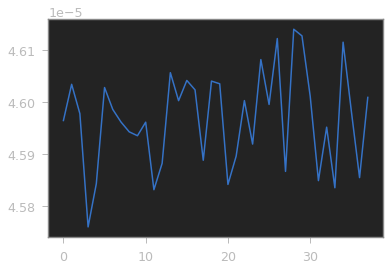

In [26]:
plt.plot(np.array(tlosses)[:, 1])

In [46]:
torch.save(reg_camera_1.state_dict(), 'models/head/reg_camera_1.pt')
torch.save(reg_camera_2.state_dict(), 'models/head/reg_camera_2.pt')
torch.save(aux_head.state_dict(), 'models/head/aux_head.pt')

In [22]:
reg_camera_1.load_state_dict(torch.load('models/head/reg_camera_1.pt'))
reg_camera_2.load_state_dict(torch.load('models/head/reg_camera_2.pt'))
aux_head.load_state_dict(torch.load('models/head/aux_head.pt'))

<All keys matched successfully>